In [1]:
# ============================================================
#                 PHYSICS-INFORMED ELASTICITY (2D)
# ============================================================
# - Neural network with sine activation (SIREN-like)
# - Trained first with Adam, then refined with L-BFGS
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import time, random
import matplotlib.pyplot as plt

In [35]:
 
# ============================================================
# 1. Device setup and reproducibility
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

manualSeed = 1234
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# ============================================================
# 2. Neural network definition
# ============================================================
class Net2D(nn.Module):
    def __init__(self, n_input=2, n_output=2, n_layer=8, n_nodes=80):
        super().__init__()
        self.input = nn.Linear(n_input, n_nodes)
        self.hidden = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for _ in range(n_layer)])
        self.output = nn.Linear(n_nodes, n_output)
        
        # Xavier initialization
        for L in [self.input, self.output] + list(self.hidden):
            nn.init.xavier_uniform_(L.weight)
            nn.init.normal_(L.bias, std=1e-3)

        # Sine activation (for oscillatory fields)
        self.act = torch.sin

    def forward(self, x):
        y = self.act(self.input(x))
        for L in self.hidden:
            y = self.act(L(y))
        return self.output(y)  # -> [u, v]

# ============================================================
# 3. Domain definition and collocation points
# ============================================================
nelx, nely = 150, 150
xs = np.linspace(0.0, 1.0, nelx + 1)
ys = np.linspace(0.0, 1.0, nely + 1)
X, Y = np.meshgrid(xs, ys)
pts = np.hstack([X.reshape(-1, 1, order='F'), Y.reshape(-1, 1, order='F')])
N_total = pts.shape[0]

# Convert to torch tensor
data = torch.tensor(pts, dtype=torch.float32, device=device, requires_grad=True)

# Boundary indices (right edge x = 1.0)
tol = 1e-6
right_idx = np.where(np.abs(pts[:, 0] - 1.0) < tol)[0]
right_idx_t = torch.tensor(right_idx, dtype=torch.long, device=device)

# ============================================================
# 4. Material and loading definition
# ============================================================
nu = 0.3               # Poisson's ratio
T = 1.0                # Traction on right edge
E_node = torch.ones((N_total, 1), device=device)  # Young's modulus field (homogeneous)

# ============================================================
# 5. Build the neural network
# ============================================================
net_uv = Net2D(n_input=2, n_output=2, n_layer=8, n_nodes=80).to(device)

# Hard boundary condition: u = v = 0 on x = 0
def uv_tilde(pt):
    xcoord = pt[:, 0:1]
    out = net_uv(pt)
    return xcoord * out  # ensures u=v=0 when x=0

 

def energy_equilibrium_loss(alpha=1e-2, beta=1e-2, eps=1e-8, w_eq=1e-2):
    """Compute total energy + equilibrium residual"""
    uv = uv_tilde(data)
    u, v = uv[:, 0:1], uv[:, 1:2]

    # Derivatives
    du = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dv = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)[0]

    du_x, du_y = du[:, 0:1], du[:, 1:2]
    dv_x, dv_y = dv[:, 0:1], dv[:, 1:2]

    # Strains
    ex = du_x
    ey = dv_y
    gamma_xy = du_y + dv_x

    # Constitutive law (plane stress)
    G = E_node / (2.0 * (1.0 + nu))
    lam = E_node * nu / (1.0 - nu**2)
    sx = 2.0 * G * ex + lam * (ex + ey)
    sy = 2.0 * G * ey + lam * (ex + ey)
    txy = G * gamma_xy

    # Internal energy
    w_density = 0.5 * (sx * ex + sy * ey + txy * gamma_xy)
    Eint = torch.mean(w_density)

    # External energy (traction)
    u_boundary = u[right_idx_t]
    Eext = - T * torch.mean(u_boundary)

    # ---------- Equilibrium residual ----------
    dsx_dx = torch.autograd.grad(sx, data, torch.ones_like(sx), retain_graph=True, create_graph=True)[0][:, 0:1]
    dsy_dy = torch.autograd.grad(sy, data, torch.ones_like(sy), retain_graph=True, create_graph=True)[0][:, 1:1+1]
    dtxy_dx = torch.autograd.grad(txy, data, torch.ones_like(txy), retain_graph=True, create_graph=True)[0][:, 0:1]
    dtxy_dy = torch.autograd.grad(txy, data, torch.ones_like(txy), retain_graph=True, create_graph=True)[0][:, 1:1+1]

    rx = dsx_dx + dtxy_dy
    ry = dtxy_dx + dsy_dy
    equilibrium_residual = torch.mean(rx**2 + ry**2)
  
    # ---------- Total loss ----------
    loss = Eint + Eext + equilibrium_residual
 
    return loss, Eint, Eext, equilibrium_residual


# ============================================================
# 7. Stage 1: Pretraining with Adam
# ============================================================
epochs = 601
lr = 1e-2
optimizer = torch.optim.Adam(net_uv.parameters(), lr=lr)
loss_history = []

print("\n=====================")
print(" Stage 1: Adam Training")
print("=====================")
start = time.time()

for ep in range(epochs):
    optimizer.zero_grad()
    #loss, Eint, Eext = energy_loss_barrier()
    loss, Eint, Eext, R_eq = energy_equilibrium_loss()


    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    loss_history.append(loss_val)
    if ep % 200 == 0 or ep == epochs - 1:
        print(f"Epoch {ep:5d}/{epochs} | loss={loss_val:.6e} | Eint={Eint.item():.4e} | Eext={Eext.item():.4e}")

print(f"Adam training completed in {(time.time()-start):.2f} s")

# ============================================================
# 8. Stage 2: Refinement with L-BFGS
# ============================================================
print("\n=====================")
print(" Stage 2: L-BFGS Refinement")
print("=====================")

# Define L-BFGS optimizer
optimizer_lbfgs = torch.optim.LBFGS(
    net_uv.parameters(),
    max_iter=600,  # Let L-BFGS handle iterations internally
    max_eval=600,
    tolerance_grad=1e-7,
    tolerance_change=1.0 * np.finfo(float).eps,
    history_size=100,
    lr=1.0,
    line_search_fn="strong_wolfe"
)
 

start = time.time()
print("Starting L-BFGS optimization...")

def closure():
    optimizer_lbfgs.zero_grad()
    loss, Eint, Eext, R_eq = energy_loss_barrier()
    loss.backward()
    # Optional: print progress every 200 internal iterations
    closure.iter_count += 1
    if closure.iter_count % 1 == 0:
        print(f"Iter {closure.iter_count:5d} | "
              f"loss={loss.item():.6e} | "
              f"Eint={Eint.item():.4e} | "
              f"Eext={Eext.item():.4e} | "
              f"R_eq={R_eq.item():.4e}")
    return loss

# Initialize iteration counter for printing
closure.iter_count = 0

# Run optimizer (it will handle all iterations internally)
optimizer_lbfgs.step(closure)

print(f"L-BFGS optimization completed in {(time.time()-start):.2f} s")
 


Device: cuda

 Stage 1: Adam Training
Epoch     0/601 | loss=-1.280440e-01 | Eint=3.5575e-02 | Eext=-2.4124e-01
Epoch   200/601 | loss=-4.896298e-01 | Eint=4.8803e-01 | Eext=-9.7823e-01
Epoch   400/601 | loss=-4.904900e-01 | Eint=4.8933e-01 | Eext=-9.8017e-01
Epoch   600/601 | loss=-4.912146e-01 | Eint=4.9043e-01 | Eext=-9.8194e-01
Adam training completed in 105.38 s

 Stage 2: L-BFGS Refinement
Starting L-BFGS optimization...
Iter     1 | loss=-4.912183e-01 | Eint=4.9035e-01 | Eext=-9.8186e-01 | R_eq=2.8983e-04
Iter     2 | loss=-4.909213e-01 | Eint=4.9955e-01 | Eext=-9.9094e-01 | R_eq=4.6647e-04
Iter     3 | loss=-4.912184e-01 | Eint=4.9059e-01 | Eext=-9.8210e-01 | R_eq=2.8990e-04
Iter     4 | loss=-4.912187e-01 | Eint=4.9055e-01 | Eext=-9.8205e-01 | R_eq=2.9002e-04
Iter     5 | loss=-4.912199e-01 | Eint=4.9035e-01 | Eext=-9.8186e-01 | R_eq=2.9059e-04
Iter     6 | loss=-4.912377e-01 | Eint=4.8871e-01 | Eext=-9.8025e-01 | R_eq=3.0094e-04
Iter     7 | loss=-4.912654e-01 | Eint=4.8764e-

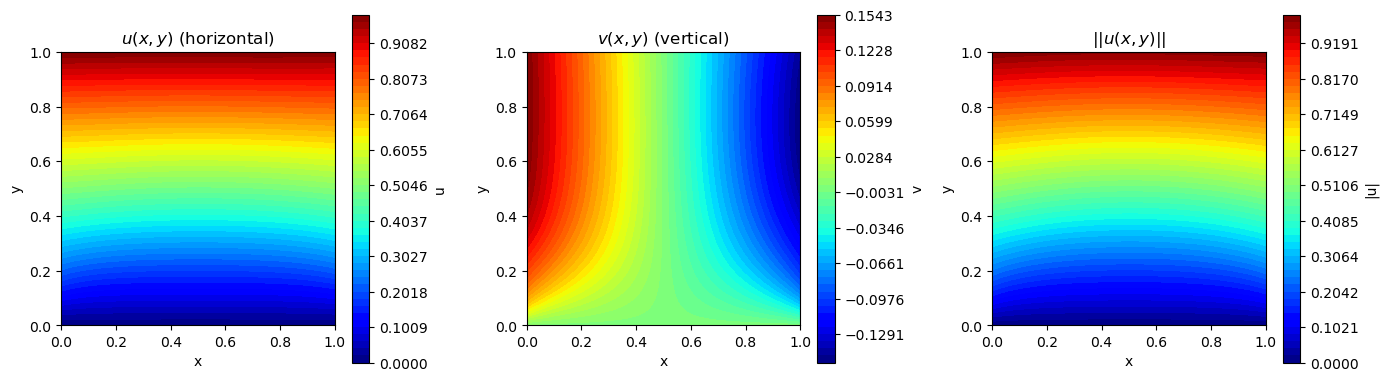

In [36]:
# ============================================================
# Postprocessing: displacement field and displacement norm
# ============================================================
net_uv.eval()
with torch.no_grad():
    uv_pred = uv_tilde(data).cpu().numpy()
u_np = uv_pred[:, 0].reshape((nely + 1, nelx + 1), order='F')
v_np = uv_pred[:, 1].reshape((nely + 1, nelx + 1), order='F')

# Compute displacement magnitude (norm)
disp_norm = np.sqrt(u_np**2 + v_np**2)

# Mesh for plotting
x = np.linspace(0, 1, nelx + 1)
y = np.linspace(0, 1, nely + 1)
X, Y = np.meshgrid(x, y)

# ============================================================
# Plot displacement components and norm
# ============================================================
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Define color levels
levels_u = np.linspace(u_np.min(), u_np.max(), 50)
levels_v = np.linspace(v_np.min(), v_np.max(), 50)
levels_norm = np.linspace(disp_norm.min(), disp_norm.max(), 50)

# --- u(x,y): horizontal displacement ---
cf0 = axs[0].contourf(X, Y, u_np.T, levels=levels_u, cmap='jet')
axs[0].set_title(r'$u(x,y)$ (horizontal)', fontsize=12)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
plt.colorbar(cf0, ax=axs[0], label='u')

# --- v(x,y): vertical displacement ---
cf1 = axs[1].contourf(X, Y, v_np.T, levels=levels_v, cmap='jet')
axs[1].set_title(r'$v(x,y)$ (vertical)', fontsize=12)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')
plt.colorbar(cf1, ax=axs[1], label='v')

# --- |u| displacement magnitude ---
cf2 = axs[2].contourf(X, Y, disp_norm.T, levels=levels_norm, cmap='jet')
axs[2].set_title(r'$||u(x,y)||$', fontsize=12)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal')
plt.colorbar(cf2, ax=axs[2], label='|u|')

plt.tight_layout()
plt.show()
